In [1]:
import numpy as np
import pandas as pd
import os
from datetime import time, datetime, timedelta

Project of predicting the time of a running activity

# Load data

In [2]:
# Extract project df
PROJECT_URL = 'https://raw.githubusercontent.com/AdrianSzymczyk/running-ml-project/main/data/activity_log.csv'
df = pd.read_csv(PROJECT_URL)
df.head()

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Number of Laps
0,Running,7/15/20 9:41,Cherry Hill Running,6.00,530,0:43:55,141,160,176,182,7:19,6:20,169,173,1.26,00:02.3,7
1,Running,7/14/20 17:45,Cherry Hill Running,6.50,587,0:47:04,144,160,172,182,7:14,6:35,183,187,1.29,03:32.7,7
2,Running,7/13/20 18:57,Cherry Hill Running,5.01,392,0:40:29,128,151,170,180,8:05,5:49,124,124,1.17,00:04.1,6
3,Running,7/12/20 18:44,Cherry Hill Running,7.01,633,0:52:55,142,157,172,180,7:33,5:00,215,219,1.24,00:05.1,8
4,Running,7/11/20 19:35,Cherry Hill Running,5.19,419,0:41:35,129,143,170,178,8:01,6:48,76,80,1.18,01:27.1,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Activity Type      689 non-null    object 
 1   Date               689 non-null    object 
 2   Title              689 non-null    object 
 3   Distance           689 non-null    float64
 4   Calories           689 non-null    object 
 5   Time               689 non-null    object 
 6   Avg HR             689 non-null    object 
 7   Max HR             689 non-null    object 
 8   Avg Run Cadence    689 non-null    object 
 9   Max Run Cadence    689 non-null    object 
 10  Avg Pace           689 non-null    object 
 11  Best Pace          689 non-null    object 
 12  Elev Gain          689 non-null    object 
 13  Elev Loss          689 non-null    object 
 14  Avg Stride Length  689 non-null    float64
 15  Best Lap Time      689 non-null    object 
 16  Number of Laps     689 non

# Preprocessing

### Delete rows with missing values 

In [4]:
df = df[~df[['Distance', 'Avg HR', 'Max HR', 'Avg Pace', 'Avg Run Cadence', 'Elev Gain', 'Elev Loss']].isin(['--']).any(axis=1)]

#### Reset indices after deleting rows

In [5]:
df = df.reset_index(drop=True)

## Convert Avg HR Max HR columns into numeric type

In [6]:
df['Elev Gain'] = df['Elev Gain'].apply(lambda x: int(str(x).replace(',', '')))
df['Elev Loss'] = df['Elev Loss'].apply(lambda x: int(str(x).replace(',', '')))

In [7]:
df['Avg HR'] = df['Avg HR'].astype(int)
df['Max HR'] = df['Max HR'].astype(int)
df['Avg Run Cadence'] = df['Avg Run Cadence'].astype(int)
df['Max Run Cadence'] = df['Max Run Cadence'].astype(int)
df['Elev Gain'] = df['Elev Gain'].astype(float)
df['Elev Loss'] = df['Elev Loss'].astype(float)

### Fix problem with missing leading zeros in Time column

#### Convert column Time values with format %M:%S.%MS to format %H:%M:%S

In [8]:
invalid_time_indices = df[df['Time'].apply(lambda x: x[-2] == '.')].index

In [9]:
df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x, '%M:%S.%f').time() if(x[-2] == '.') else datetime.strptime(x, '%H:%M:%S').time())

### Convert data units from Miles to Kilometers

In [10]:
df.head(2)

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Number of Laps
0,Running,7/15/20 9:41,Cherry Hill Running,6.0,530,00:43:55,141,160,176,182,7:19,6:20,169.0,173.0,1.26,00:02.3,7
1,Running,7/14/20 17:45,Cherry Hill Running,6.5,587,00:47:04,144,160,172,182,7:14,6:35,183.0,187.0,1.29,03:32.7,7


#### Distance conversion

In [11]:
df['Distance'] = df['Distance'].apply(lambda x: round(x * 1.60934, 2))

#### Pace conversion 

In [12]:
def pace_to_km(pace):
    mile = 1.60934 
    minutes, seconds = pace.split(':')
    pace_in_seconds = int(minutes) * 60 + int(seconds)
    pace_per_km = round(pace_in_seconds / mile)
    return pace_per_km

#### Avg Pace conversion

In [13]:
df['Avg Pace'] = df['Avg Pace'].apply(pace_to_km)

#### Best Pace conversion

In [14]:
df['Best Pace'] = df['Best Pace'].apply(pace_to_km)

### Convert Time into numeric representation as total number of seconds

In [15]:
df['Time'] = pd.to_timedelta(df['Time'].astype(str)).dt.total_seconds().astype(int)

## Drop columns which won't be usefull for out regression

In [17]:
df = df.drop(['Activity Type', 'Date', 'Title', 'Calories', 'Best Lap Time', 'Number of Laps'], axis=1)

In [70]:
df.head()

,Distance,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length
0,9.66,2635,141,160,176,182,273,236,169.0,173.0,1.26
1,10.46,2824,144,160,172,182,270,245,183.0,187.0,1.29
2,8.06,2429,128,151,170,180,301,217,124.0,124.0,1.17
3,11.28,3175,142,157,172,180,281,186,215.0,219.0,1.24
4,8.35,2495,129,143,170,178,299,254,76.0,80.0,1.18


In [18]:
df.describe()

,Distance,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.00000
mean,8.499543,2234.938486,144.457413,165.668770,177.037855,189.063091,258.143533,193.337539,264.821767,265.157729,1.34082
std,6.263989,1628.836675,14.036251,15.044665,7.085251,10.158264,38.750140,48.590720,276.334467,277.648169,0.17664
min,0.400000,66.000000,102.000000,116.000000,162.000000,168.000000,160.000000,16.000000,3.000000,3.000000,0.90000
25%,3.400000,919.250000,135.000000,156.000000,172.000000,180.000000,249.000000,167.000000,63.000000,59.000000,1.25000
50%,6.570000,1822.000000,143.000000,165.000000,176.000000,188.000000,264.000000,194.000000,153.000000,148.500000,1.29500
75%,12.860000,3327.250000,152.000000,176.000000,180.000000,194.000000,279.000000,228.000000,403.750000,397.750000,1.36000
max,28.980000,7200.000000,188.000000,209.000000,202.000000,246.000000,400.000000,321.000000,1262.000000,1521.000000,1.86000


## Looking for Correlations

In [19]:
corr_matrix = df.corr(numeric_only=True)

In [20]:
corr_matrix['Time'].sort_values(ascending=False)

Time                 1.000000
Distance             0.992891
Elev Gain            0.821551
Elev Loss            0.818582
Avg Pace             0.252870
Max HR               0.134543
Best Pace            0.038627
Avg HR              -0.053432
Max Run Cadence     -0.178102
Avg Stride Length   -0.319321
Avg Run Cadence     -0.331184
Name: Time, dtype: float64

# Split dataset

In [21]:
from sklearn.model_selection import train_test_split

def get_data_splits(X, y, train_size=0.7):
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [22]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_splits(X=df.drop('Time', axis=1), y=df['Time'].copy())

# Train, adjust hyperparameters and evaluate models

## -->Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lin_reg = LinearRegression()
# Train model on the training set
lin_reg.fit(X_train, y_train)
# Predict values 
y_pred = lin_reg.predict(X_test)
# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} seconds')
print(f'Mean absolute error: {mae:.2f} seconds')

Mean squared error: 125.87 seconds
Mean absolute error: 89.27 seconds


In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('Outcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Outcomes: [110.84866851 144.55344934 129.25147263 161.62410046 121.37732389
 122.99147764 122.41173521 195.31473917 121.38526428 110.5170801 ]
Mean: 134.0275311224114
Standard deviation: 25.135383472508543


### <u> Linear Regression with PolynomialFeature </u> BEST ONE

In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(include_bias=False),
    StandardScaler(),
    LinearRegression()
)
# Train model on training set
polynomial_regression.fit(X_train, y_train)
# Predict valeus 
y_pred = polynomial_regression.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} seconds')
print(f'Mean absolute error: {mae:.2f} seconds')

scores = cross_val_score(polynomial_regression, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('\nOutcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Mean squared error: 4.97 seconds
Mean absolute error: 3.66 seconds

Outcomes: [2.88069143 4.76310854 4.74567874 4.97668518 5.00759993 4.19957946
 3.12862257 5.36782983 4.42390053 4.41473395]
Mean: 4.390843015998032
Standard deviation: 0.765153380056676


In [66]:
pd.DataFrame({'y_test': y_test.values, 'y_pred': y_pred})

,y_test,y_pred
0,178,177.915764
1,2323,2323.796140
2,2387,2383.909050
3,3333,3328.205018
4,888,887.992837
...,...,...
91,2198,2200.882907
92,300,300.930200
93,4207,4206.538827
94,2206,2209.456287


In [67]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

param_grid = {
    'poly__degree': [1,2,3,4,5,10]
}
# Create a GridSearchCV object with pipeline and hyperparamters to search over
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# Train the grid search on training set
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters: ", grid_search.best_params_)
print("Best MSE: ", np.sqrt(-grid_search.best_score_))

Best hyperparameters:  {'poly__degree': 2}
Best MSE:  4.581775283159717


## --> SVM

In [27]:
from sklearn.svm import SVR

svm_reg_pipe = make_pipeline(
    StandardScaler(),
    SVR()
)
svm_reg = SVR()
# Train model on training set
svm_reg_pipe.fit(X_train, y_train)
y_pred = svm_reg_pipe.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} seconds')
print(f'Mean absolute error: {mae:.2f} seconds')

scores = cross_val_score(svm_reg_pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('\nOutcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Mean squared error: 1756.02 seconds
Mean absolute error: 1356.99 seconds

Outcomes: [1466.89968095 1669.68806883 1463.26486306 1902.52266395 1638.04874547
 1502.05001749 1882.80397085 1887.80570002 1615.47976625 1827.85726883]
Mean: 1685.6420745703829
Standard deviation: 168.95372250943186


## --> RandomForest

In [28]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)
# Train model on training set
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} seconds')
print(f'Mean absolute error: {mae:.2f} seconds')

scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('\nOutcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Mean squared error: 98.20 seconds
Mean absolute error: 60.34 seconds

Outcomes: [ 85.1252768   83.95746587  88.81248264 143.82963262 129.2364996
 101.31598102 108.50111475 182.59589472  98.23072881 135.35519369]
Mean: 115.69602705203451
Standard deviation: 30.10837161310924


In [ ]:
pd.DataFrame({'y_test': y_test.values, 'y_pred': y_pred})

In [30]:
from sklearn.linear_model import SGDRegressor

# Train model on training set
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train, y_train)
y_pred = sgd_reg.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} seconds')
print(f'Mean absolute error: {mae:.2f} seconds')

Mean squared error: 150790542828085.09 seconds
Mean absolute error: 138398999995347.92 seconds


In [32]:
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': 10.0 ** -np.arange(1, 4),
    'power_t': np.arange(0, 2, 0.25),
    'max_iter': np.arange(1000, 10000, 1000),
}
model = SGDRegressor()
rnd_search = RandomizedSearchCV(model, param_grid)
rnd_search.fit(X_train, y_train)
print('Best hyperparamenters: ', rnd_search.best_params_)
print("Best MSE: ", rnd_search.best_score_)

Best hyperparamenters:  {'power_t': 0.25, 'penalty': 'l2', 'max_iter': 9000, 'loss': 'huber', 'learning_rate': 'invscaling', 'eta0': 0.01, 'alpha': 1e-05}
Best MSE:  -0.6967045087360592


In [40]:
model = SGDRegressor(
    loss='huber', penalty='l2', alpha=1e-05, max_iter=9000,
    learning_rate='invscaling', eta0=0.01, power_t=0.25,
    warm_start=True)

Epoch: 00 | train_mse: 846728.61908, val_mse: 611723.79375
Epoch: 10 | train_mse: 687068.59140, val_mse: 530363.55773
Epoch: 20 | train_mse: 505990.78173, val_mse: 372028.10000
Epoch: 30 | train_mse: 462282.07695, val_mse: 366832.11784
Epoch: 40 | train_mse: 315681.00836, val_mse: 242418.04884
Epoch: 50 | train_mse: 221918.14221, val_mse: 163426.80067
Epoch: 60 | train_mse: 154577.26046, val_mse: 119860.33605
Epoch: 70 | train_mse: 87281.82903, val_mse: 62240.10144
Epoch: 80 | train_mse: 55863.50653, val_mse: 41312.10685
Epoch: 90 | train_mse: 69429.85893, val_mse: 66804.92301
Epoch: 100 | train_mse: 34101.55713, val_mse: 23171.37515
Epoch: 110 | train_mse: 23949.02393, val_mse: 25208.02809
Epoch: 120 | train_mse: 21432.20511, val_mse: 21443.42889
Epoch: 130 | train_mse: 20037.17265, val_mse: 16273.37702
Epoch: 140 | train_mse: 21998.05114, val_mse: 24055.51101
Epoch: 150 | train_mse: 21964.64062, val_mse: 16629.32371
Epoch: 160 | train_mse: 28450.69821, val_mse: 31517.99627
Epoch: 170

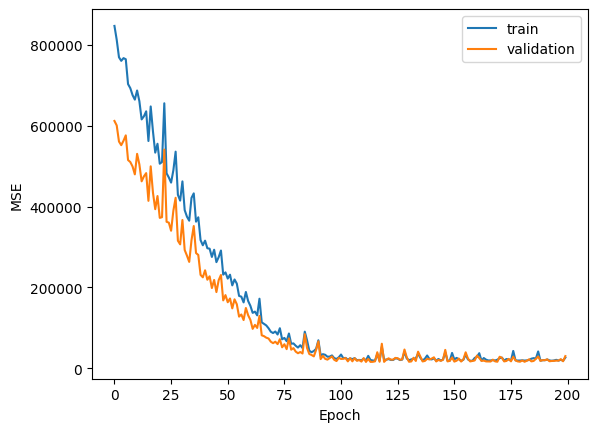

In [42]:
import matplotlib.pyplot as plt

num_epochs = 200
train_mse = []
val_mse = []

for epoch in range(num_epochs):
    # Training
    model.fit(X_train, y_train)

    # Evaluation
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)    
    train_mse.append(mean_squared_error(y_train, train_pred))
    val_mse.append(mean_squared_error(y_val, val_pred))
    
    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_mse: {train_mse[-1]:.5f}, "
            f"val_mse: {val_mse[-1]:.5f}"
        )

# Plot the MSE for each epoch
plt.plot(train_mse, label='train')
plt.plot(val_mse, label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()